# Deadlines aus Simulation (FIFO)

In [1]:
# Datenzugriff
from configs.config import get_path

# Utils
import src.utils.presenter as show
from src.utils.analize import check_constrains as check

from src.utils.production_process import initialize as init

# Extern
import math
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
pd.set_option('display.min_rows', 21)
pd.set_option('display.max_rows', 25)

In [2]:
import src.utils.figurator as fig_gen

In [3]:
basic_data_path = get_path("data", "basic")
day_count = 360
day_count = 600

df_jobs_times = pd.read_csv(basic_data_path / f"jobs_times_{day_count}_raw.csv")
df_jobs_times

,Job,Production_Plan_ID,Arrival,Ready Time,End,Processing Time
0,0,0,51,1440,3050.0,395
1,1,1,136,1440,2736.0,510
2,2,2,158,1440,2258.0,568
3,3,3,236,1440,2926.0,655
4,4,4,404,1440,3007.0,393
5,5,5,485,1440,2731.0,496
6,6,6,501,1440,2646.0,416
7,7,7,528,1440,3085.0,539
8,8,8,550,1440,2985.0,597
9,9,9,559,1440,2970.0,540


## II) Log-Normalverteilung

Für jede Gruppe in der Spalte `Production_Plan_ID`

In [4]:
def add_groupwise_lognormal_deadlines_by_group_mean(
    df: pd.DataFrame,
    sigma: float = 0.2,
    seed: int = 42
) -> pd.DataFrame:
    """
    Für jede Gruppe in 'Production_Plan_ID' wird eine Lognormalverteilung
    mit Parameter mu so berechnet, dass der Mittelwert der Deadlines genau
    dem Mittelwert der 'End'-Werte der Gruppe entspricht.

    Jeder Deadline-Wert in der Gruppe wird einzeln zufällig aus dieser Verteilung gezogen.

    Parameters
    ----------
    df : pd.DataFrame
        Muss Spalten 'Production_Plan_ID' und 'End' enthalten.
    sigma : float, optional
        Standardabweichung der Lognormalverteilung (Default 0.2).
    seed : int, optional
        Zufalls-Seed (Default 42).

    Returns
    -------
    pd.DataFrame
        Kopie von df mit neuer Spalte 'Deadline' (float, 1 Dezimalstelle).
    """
    np.random.seed(seed)
    df_out = df.copy()
    df_out['Deadline'] = np.nan

    for plan_id, grp in df_out.groupby('Production_Plan_ID'):
        target_flow_mean = grp['End'].mean() - grp['Ready Time'].mean()
        mu = np.log(target_flow_mean) - 0.5 * sigma**2

        # Für jede Zeile in Gruppe eine Deadline aus LogNormal(mu, sigma)
        flow_budgets = np.random.lognormal(mean=mu, sigma=sigma, size=len(grp))
        df_out.loc[grp.index, 'Deadline'] = df_out.loc[grp.index, 'Ready Time'] + np.round(flow_budgets) 

    return df_out

In [5]:
df_times = add_groupwise_lognormal_deadlines_by_group_mean(df_jobs_times, sigma=0.3)
df_times

,Job,Production_Plan_ID,Arrival,Ready Time,End,Processing Time,Deadline
0,0,0,51,1440,3050.0,395,3806.0
1,1,1,136,1440,2736.0,510,2999.0
2,2,2,158,1440,2258.0,568,3725.0
3,3,3,236,1440,2926.0,655,2443.0
4,4,4,404,1440,3007.0,393,3814.0
5,5,5,485,1440,2731.0,496,3488.0
6,6,6,501,1440,2646.0,416,3023.0
7,7,7,528,1440,3085.0,539,4994.0
8,8,8,550,1440,2985.0,597,3813.0
9,9,9,559,1440,2970.0,540,3137.0


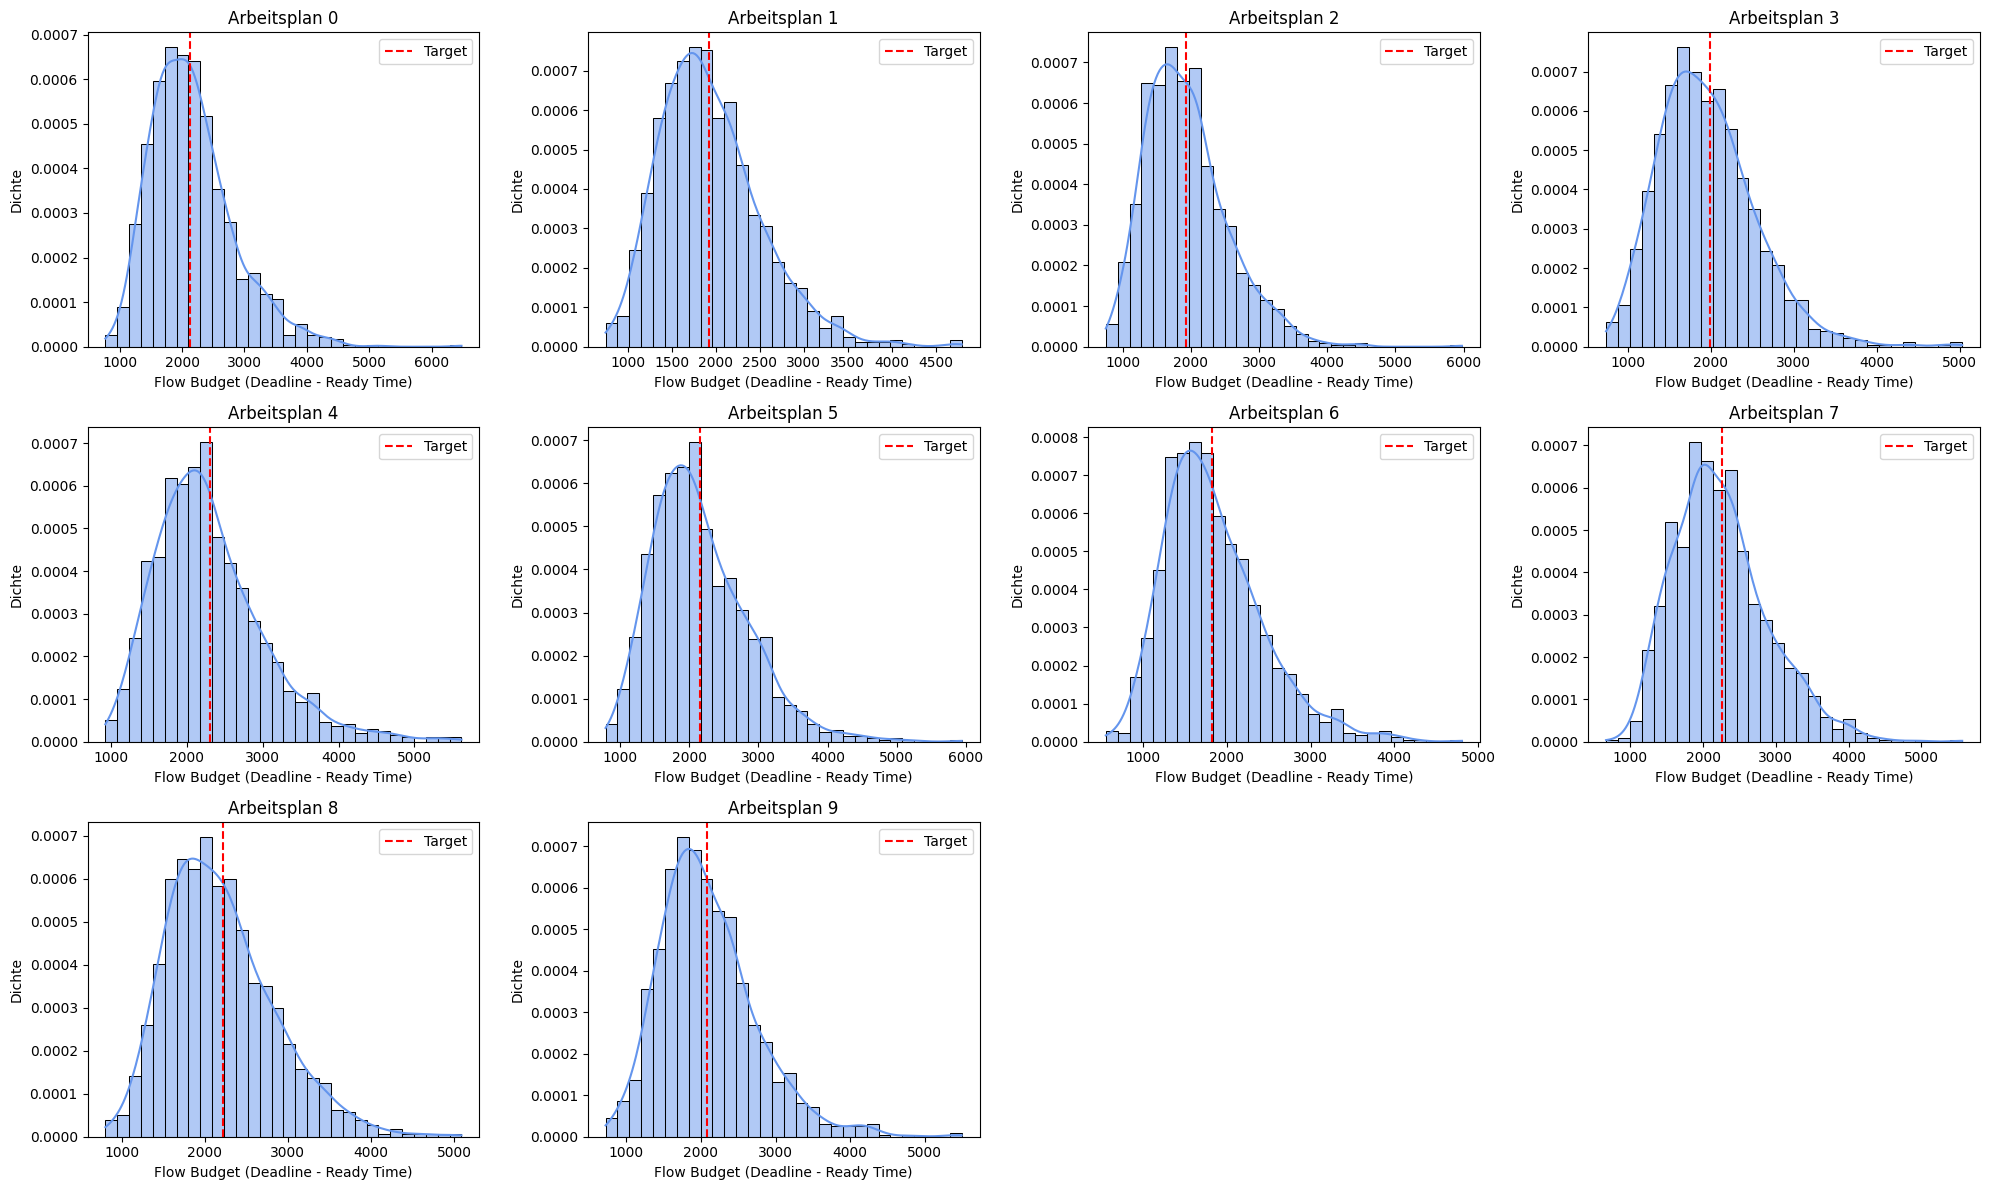

In [6]:
def plot_empirical_flow_budget_distributions(df_times: pd.DataFrame, bins: int = 30):
    """
    Plottet für jede Gruppe in 'Production_Plan_ID' das Histogramm + KDE
    der Flow Budgets (Deadline - Ready Time) auf Basis von df_times.
    Zusätzlich wird der Zielwert (End.mean - Ready Time.mean) als rote Linie eingezeichnet.

    Parameters
    ----------
    df_times : pd.DataFrame
        Muss Spalten 'Production_Plan_ID', 'Deadline', 'Ready Time', 'End' enthalten.
    bins : int
        Anzahl der Bins im Histogramm.
    """
    groups = df_times['Production_Plan_ID'].unique()
    n_groups = len(groups)
    n_cols = min(4, n_groups)
    n_rows = int(np.ceil(n_groups / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), squeeze=False)

    for idx, group in enumerate(groups):
        ax = axes[idx // n_cols][idx % n_cols]
        grp = df_times[df_times['Production_Plan_ID'] == group]
        flow_budgets = grp['Deadline'] - grp['Ready Time']
        target = grp['End'].mean() - grp['Ready Time'].mean()

        sns.histplot(flow_budgets, bins=bins, kde=True, stat='density', ax=ax, color='cornflowerblue', edgecolor='black')

        ax.axvline(target, color='red', linestyle='--', label='Target')
        ax.set_title(f'Arbeitsplan {group}')
        ax.set_xlabel('Flow Budget (Deadline - Ready Time)')
        ax.set_ylabel('Dichte')
        ax.legend()

    # Leere Plots deaktivieren (wenn weniger Gruppen als Subplots)
    for j in range(idx + 1, n_rows * n_cols):
        fig.delaxes(axes[j // n_cols][j % n_cols])

    plt.tight_layout()
    plt.show()


plot_empirical_flow_budget_distributions(df_times)

## III) "Untere Begrenzung" der Deadlines

In [7]:
df_times['Deadline'] = np.maximum(df_times['Deadline'],
                                  df_times['Ready Time'] 
                                  + df_times['Processing Time'] / 2
                                 )



df_times['Deadline'] = np.ceil(df_times['Deadline']).astype(int)
df_times

,Job,Production_Plan_ID,Arrival,Ready Time,End,Processing Time,Deadline
0,0,0,51,1440,3050.0,395,3806
1,1,1,136,1440,2736.0,510,2999
2,2,2,158,1440,2258.0,568,3725
3,3,3,236,1440,2926.0,655,2443
4,4,4,404,1440,3007.0,393,3814
5,5,5,485,1440,2731.0,496,3488
6,6,6,501,1440,2646.0,416,3023
7,7,7,528,1440,3085.0,539,4994
8,8,8,550,1440,2985.0,597,3813
9,9,9,559,1440,2970.0,540,3137


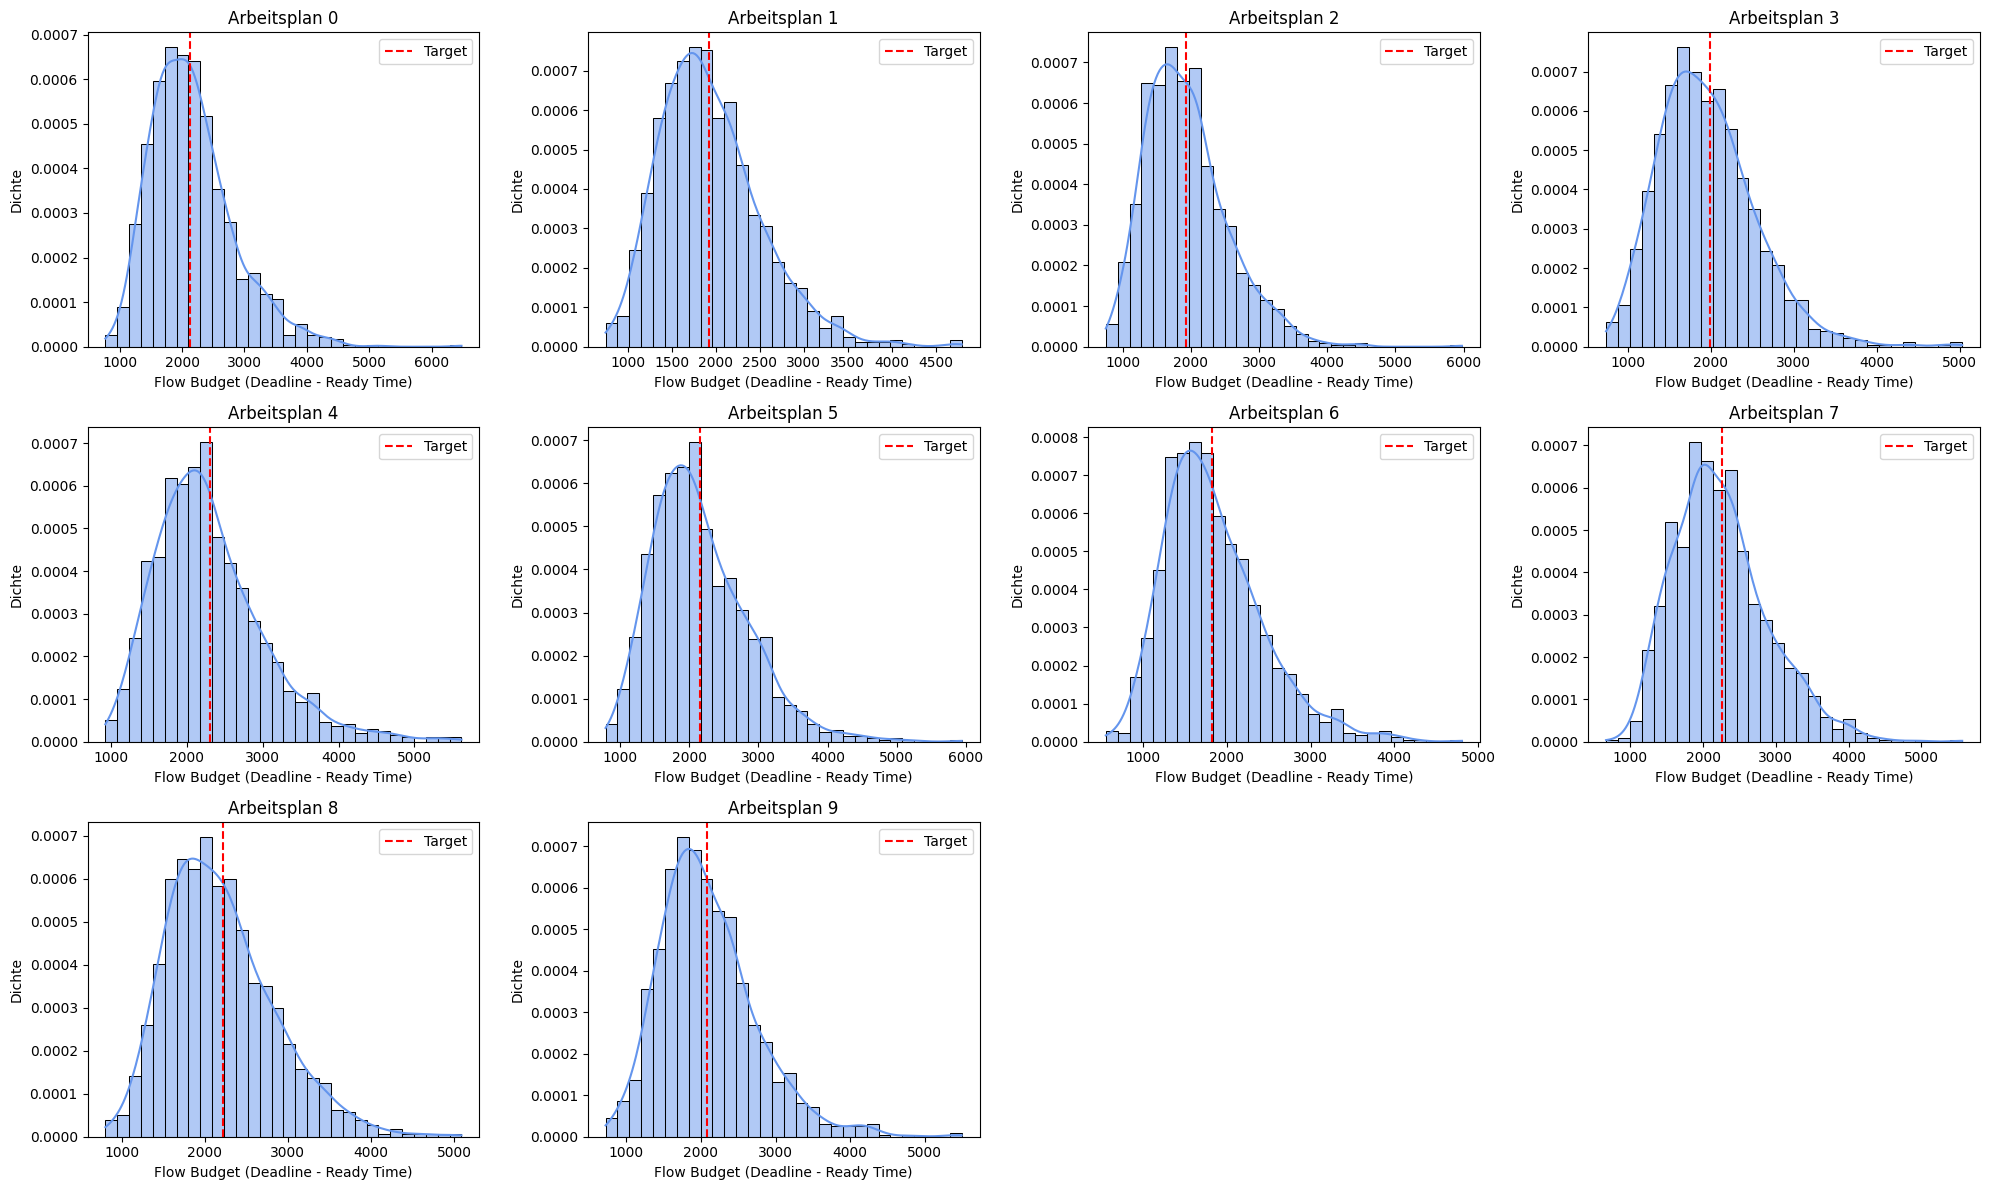

In [8]:
plot_empirical_flow_budget_distributions(df_times)

### Export

In [9]:
df_times.to_csv(basic_data_path / f"jobs_times_{day_count}_final.csv", index = False)